In [1]:
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Input

2025-11-13 00:56:31.056574: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 00:56:32.404462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-13 00:56:32.404652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-13 00:56:32.618388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-13 00:56:33.178643: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 00:56:33.181740: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [11]:
pictures_dir = pathlib.Path("pictures")
temp_ds = tf.keras.utils.image_dataset_from_directory(
  pictures_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(64, 64),
  batch_size=8)

test_ds = tf.keras.utils.image_dataset_from_directory(
  pictures_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(64, 64),
  batch_size=8)

temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()
k = (temp_batches * 8) // 10   # 80/20 split by batches
train_ds = temp_ds.take(k)
val_ds   = temp_ds.skip(k)

Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Found 21322 files belonging to 2 classes.
Using 4264 files for validation.


In [16]:
class_names = temp_ds.class_names
print(class_names)

['damage', 'no_damage']


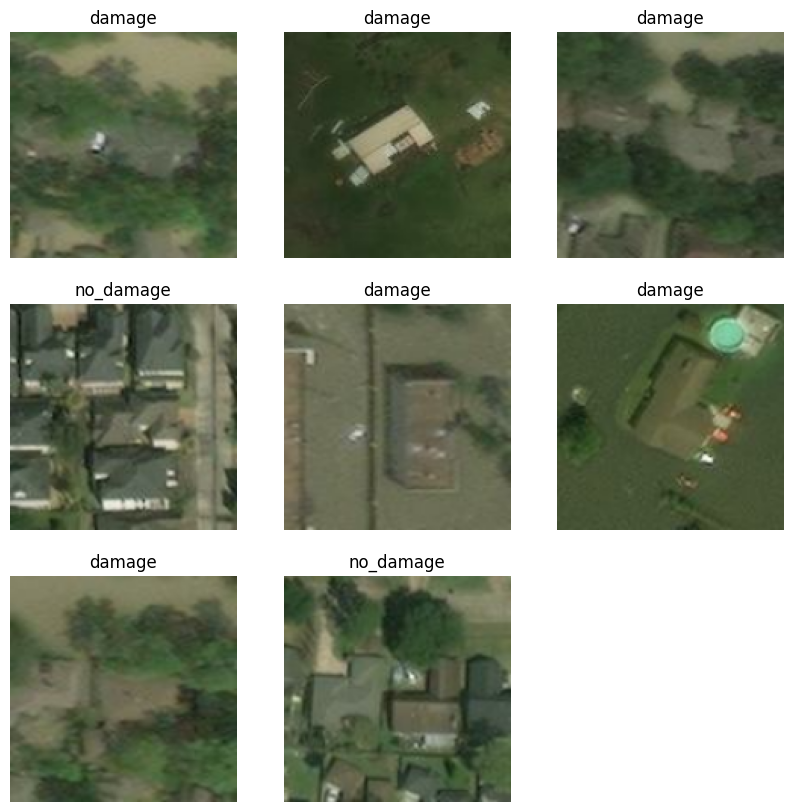

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Image dtype:", images.dtype)
    print("Label dtype:", labels.dtype)

Image batch shape: (8, 64, 64, 3)
Label batch shape: (8,)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


In [19]:
def count_samples(ds):
    total = 0
    for images, labels in ds:
        total += images.shape[0]
    return total

print("Train images:", count_samples(train_ds))
print("Validation images:", count_samples(val_ds))
print("Test images:", count_samples(test_ds))

Train images: 13648
Validation images: 3410
Test images: 4264


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds_normalized = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds_normalized = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_normalized = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.12352942 0.82156867


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_normalized = train_ds_normalized.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_normalized = val_ds_normalized.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
model_L5CNN = tf.keras.Sequential()
num_classes = 2
# Layer 1: Convolutional layer with 6 filters of size 5x5, followed by average pooling
model_L5CNN.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(150, 150, 3)))
model_L5CNN.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 5x5, followed by average pooling
model_L5CNN.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_L5CNN.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
model_L5CNN.add(Flatten())

# Layer 3: Fully connected layer with 120 neurons
model_L5CNN.add(Dense(120, activation='relu'))

# Layer 4: Fully connected layer with 84 neurons
model_L5CNN.add(Dense(84, activation='relu'))

# Output layer: Fully connected layer with num_classes neurons (e.g., 10 for MNIST)
model_L5CNN.add(Dense(num_classes, activation='softmax'))

In [23]:
model_L5CNN.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [24]:
model_L5CNN.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=5
)


Epoch 1/5
1706/1706 [==============================] - 86s 50ms/step - loss: 0.4240 - accuracy: 0.8055 - val_loss: 0.3388 - val_accuracy: 0.8551
Epoch 2/5
1706/1706 [==============================] - 83s 49ms/step - loss: 0.3257 - accuracy: 0.8620 - val_loss: 0.3173 - val_accuracy: 0.8710
Epoch 3/5
1706/1706 [==============================] - 83s 48ms/step - loss: 0.2758 - accuracy: 0.8867 - val_loss: 0.3230 - val_accuracy: 0.8669
Epoch 4/5
1706/1706 [==============================] - 82s 48ms/step - loss: 0.2240 - accuracy: 0.9116 - val_loss: 0.4056 - val_accuracy: 0.8645
Epoch 5/5
1706/1706 [==============================] - 80s 47ms/step - loss: 0.1749 - accuracy: 0.9350 - val_loss: 0.4707 - val_accuracy: 0.8551


In [25]:
test_loss, test_accuracy = model_L5CNN.evaluate(test_ds_normalized)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

533/533 [==============================] - 6s 12ms/step - loss: 0.4564 - accuracy: 0.8642
Test accuracy: 0.8642120361328125
Test loss: 0.4564037621021271


In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model_ANN = Sequential([
    Flatten(input_shape=(64,64,3)),
    Dense(4096, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

In [15]:
model_ANN.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [16]:
model_ANN.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=5
)


Epoch 1/5
1706/1706 [==============================] - 518s 303ms/step - loss: 0.8635 - accuracy: 0.6663 - val_loss: 0.6017 - val_accuracy: 0.6845
Epoch 2/5
1706/1706 [==============================] - 523s 307ms/step - loss: 0.5644 - accuracy: 0.7275 - val_loss: 0.5568 - val_accuracy: 0.7349
Epoch 3/5
1706/1706 [==============================] - 517s 303ms/step - loss: 0.5427 - accuracy: 0.7433 - val_loss: 0.5530 - val_accuracy: 0.7331
Epoch 4/5
1706/1706 [==============================] - 516s 303ms/step - loss: 0.5312 - accuracy: 0.7531 - val_loss: 0.5325 - val_accuracy: 0.7475
Epoch 5/5
1706/1706 [==============================] - 524s 307ms/step - loss: 0.5189 - accuracy: 0.7591 - val_loss: 0.5250 - val_accuracy: 0.7572


In [36]:
test_loss, test_accuracy = model_ANN.evaluate(test_ds_normalized)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

134/134 [==============================] - 3s 24ms/step - loss: 31.3940 - accuracy: 0.7357
Test accuracy: 0.735694169998169
Test loss: 31.39398956298828


In [ ]:
model_AL5 = tf.keras.Sequential([
    Input(shape=(150, 150, 3)),                      

    Conv2D(32, (3, 3), activation='relu', padding='valid'),  
    MaxPooling2D(pool_size=(2, 2)),                          

    Conv2D(64, (3, 3), activation='relu', padding='valid'),  
    MaxPooling2D(pool_size=(2, 2)),                          

    Conv2D(128, (3, 3), activation='relu', padding='valid'), 
    MaxPooling2D(pool_size=(2, 2)),                          

    Conv2D(128, (3, 3), activation='relu', padding='valid'), 
    MaxPooling2D(pool_size=(2, 2)),                          

    Flatten(),                                               
    Dropout(0.5),                                            
    Dense(512, activation='relu'),                           
    Dense(1, activation='sigmoid')                           
]) 

In [42]:
model_AL5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [43]:
model_AL5.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=5
)

Epoch 1/5
1706/1706 [==============================] - 129s 75ms/step - loss: 0.4251 - accuracy: 0.8121 - auc: 0.8656 - val_loss: 0.2611 - val_accuracy: 0.8979 - val_auc: 0.9568
Epoch 2/5
1706/1706 [==============================] - 129s 75ms/step - loss: 0.1917 - accuracy: 0.9256 - auc: 0.9737 - val_loss: 0.1717 - val_accuracy: 0.9323 - val_auc: 0.9826
Epoch 3/5
1706/1706 [==============================] - 129s 75ms/step - loss: 0.1320 - accuracy: 0.9472 - auc: 0.9874 - val_loss: 0.1633 - val_accuracy: 0.9358 - val_auc: 0.9856
Epoch 4/5
1706/1706 [==============================] - 130s 76ms/step - loss: 0.1089 - accuracy: 0.9566 - auc: 0.9913 - val_loss: 0.1074 - val_accuracy: 0.9587 - val_auc: 0.9927
Epoch 5/5
1706/1706 [==============================] - 128s 75ms/step - loss: 0.0917 - accuracy: 0.9634 - auc: 0.9938 - val_loss: 0.1150 - val_accuracy: 0.9551 - val_auc: 0.9929


In [48]:
results = model_AL5.evaluate(test_ds_normalized,  return_dict=True)
print("Test accuracy:", results['accuracy'])
print("Test loss:", results['loss'])

533/533 [==============================] - 9s 16ms/step - loss: 0.1046 - accuracy: 0.9587 - auc: 0.9945
Test accuracy: 0.9587242007255554
Test loss: 0.10463128983974457


0.96 > 0.86, so model_AL5 is the best model

In [49]:
model_AL5.save("model.keras")